In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

In [12]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI')
from torch.utils.data import DataLoader, Dataset, TensorDataset
from data .Modelnet10toSet import *
import matplotlib.pyplot as plt
import random

In [8]:
!pwd

/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/Tutorials/DeepSets  PointCloud


In [17]:
%cd Tutorials/
!pwd

/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/Tutorials
/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/Tutorials


In [26]:
train_data = PointCloudData()
test_data = PointCloudData(None, Train=False, folder='test', transform=None)
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
test_loader = DataLoader(test_data, batch_size=32,shuffle=True)

In [18]:
dataset = PointCloudData()
class_names =   [ 'bathtub' , 'bed' , 'chair',  'desk' , 'dresser' , 'monitor' , 'night_stand' , 'sofa' ,  'table' ,  'toilet']
sampleSet = []
for i in range(0,len(class_names)):
    for j in range(0,len(dataset)):
        if i == dataset[j]['category']:
            sampleSet.append(dataset[j]['pointcloud'])
            break

In [19]:
set_channels = 3
set_size = 2048
  
hidden_dim = 128
iters = 10
latent_dim = 64
lr = 0.001
n_epochs = 50
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [20]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [32]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [33]:
model = torch.load('/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/src/MaxEncoder_model_modelnet10.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [34]:
miNet.load_state_dict(torch.load('/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/src/MaxEncoder_model_modelnet10.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

Tamaño del dataset:  3991
Numero de elementos por muestra:  3 que se corresponde con la etiqueta, el conjunto de puntos y la mascara
Tamaño del conjunto de puntos:  (3, 2048)
Representación del conjunto de puntos: 


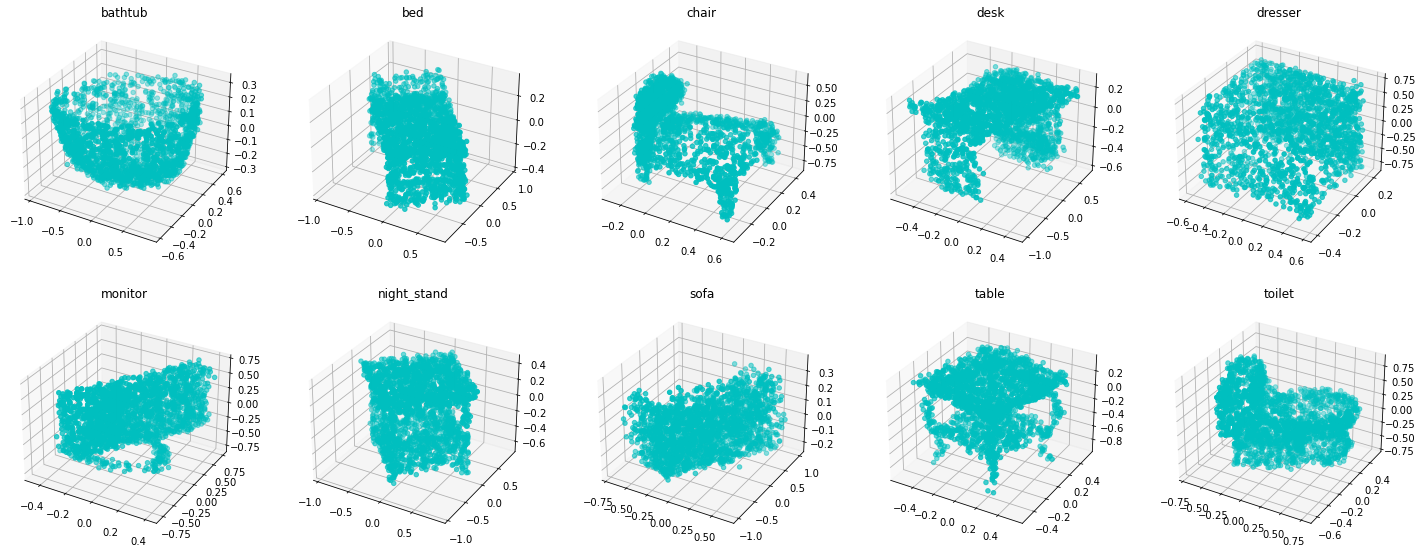

In [36]:
print('Tamaño del dataset: ',len(dataset))
print('Numero de elementos por muestra: ',len(dataset[0]),'que se corresponde con la etiqueta, el conjunto de puntos y la mascara')
print('Tamaño del conjunto de puntos: ',dataset[0]['pointcloud'].numpy().shape)
print('Representación del conjunto de puntos: ')
fig = plt.figure(figsize=(25, 25))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = sampleSet[i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c',marker='o',s=20)
    plt.title(class_names[i])
    # ==============

In [37]:
miNet = miNet
miNet.eval()
losses = []
accs = []
device = 'cpu'
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        label = sample['category']
        target_set = sample['pointcloud']
        target_mask = sample['mask']
        output = miNet(target_set.to(device),target_mask.to(device))
        loss = F.cross_entropy(output.to(device), label.to(device))
        acc = (output.max(dim=1)[1].to(device) == label.to(device)).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0: 100%|█████████████████████████████| 29/29 [01:26<00:00,  2.97s/batch, acc=83.3, loss=0.419]

loss: 0.48, acc: 0.85


In [43]:
for name, param in miNet.named_parameters():
    print(name, param.size())

conv.0.weight torch.Size([128, 3, 1])
conv.0.bias torch.Size([128])
conv.2.weight torch.Size([128, 128, 1])
conv.2.bias torch.Size([128])
lin.0.weight torch.Size([128, 128])
lin.0.bias torch.Size([128])
lin.2.weight torch.Size([64, 128])
lin.2.bias torch.Size([64])
classifier.0.weight torch.Size([64, 64])
classifier.0.bias torch.Size([64])
classifier.2.weight torch.Size([10, 64])
classifier.2.bias torch.Size([10])


In [44]:
model.classifier = nn.Sequential(*[miNet.conv[i] for i in range(3)])
print(model.classifier)

Sequential(
  (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
)


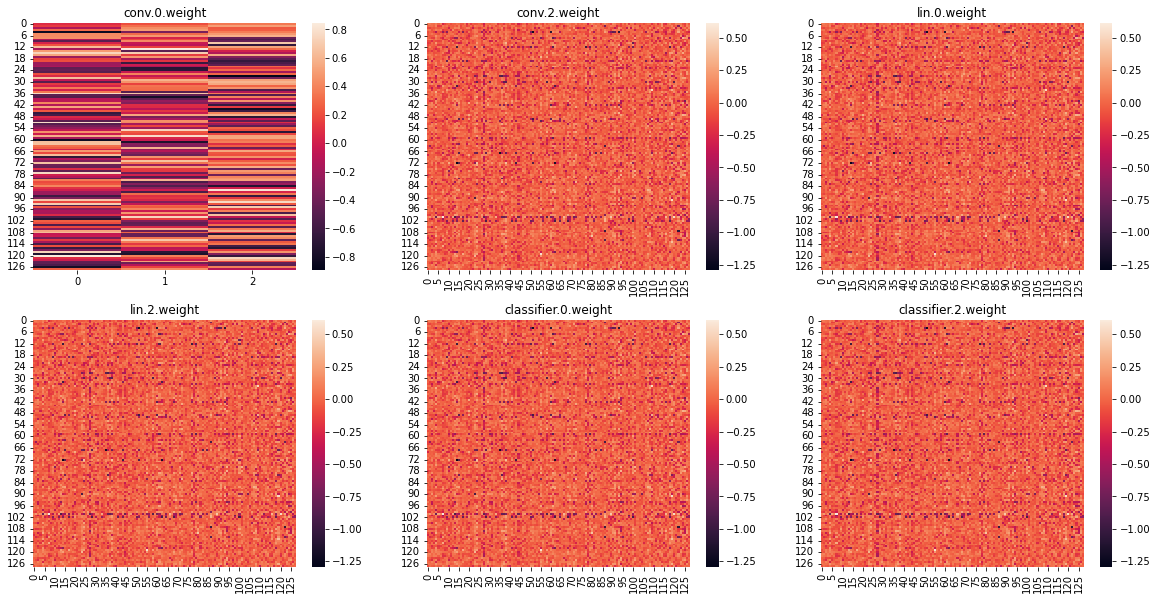

In [45]:
get_weight(miNet)

In [47]:
with torch.no_grad():
    sampleMask = torch.ones(2048)
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility".format(np.argmax(pred).item(),class_names[i]))

We obtained 0, and the expected is: bathtub with probaility
We obtained 1, and the expected is: bed with probaility
We obtained 2, and the expected is: chair with probaility
We obtained 3, and the expected is: desk with probaility
We obtained 4, and the expected is: dresser with probaility
We obtained 5, and the expected is: monitor with probaility
We obtained 6, and the expected is: night_stand with probaility
We obtained 7, and the expected is: sofa with probaility
We obtained 6, and the expected is: table with probaility
We obtained 9, and the expected is: toilet with probaility


In [48]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-2]))
print(model1)

Sequential(
  (0): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
)


In [49]:
with torch.no_grad():
    pred = model1(sampleSet[0].unsqueeze(0))
print(pred.shape)

torch.Size([1, 128, 2048])


torch.Size([1, 128])


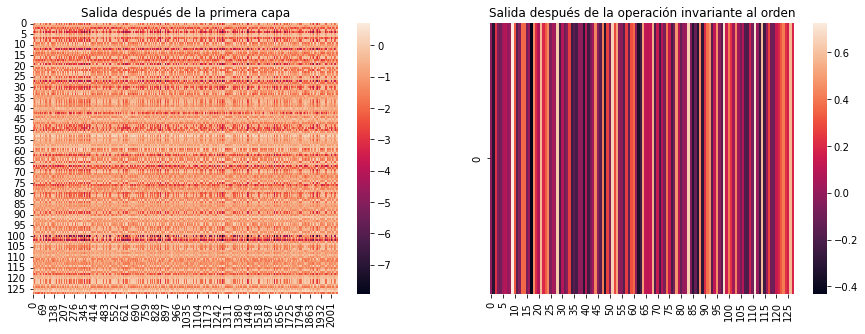

In [50]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[8].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [60]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    critical_points_z = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
        critical_points_z.append(points[2,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    z = np.array(critical_points_z)
    s = np.stack((y,x,z))
    
    return s 

In [61]:
crit = dataset[800]['pointcloud']
s = critical_points_MaxEncoder(model1,crit)
s.shape

(3, 58)

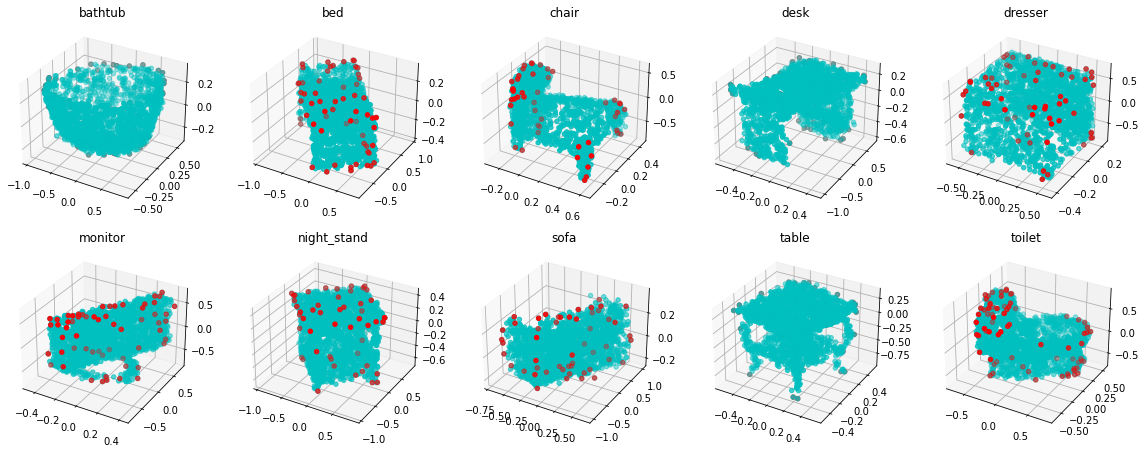

In [63]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = sampleSet[i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c',marker='o',s=20)
    surf2 = ax.scatter(crit[0,:], crit[1,:], crit[2, :],color='r',marker='o',s=20)
    plt.title(class_names[i])
plt.show()